In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate

wer  = evaluate.load('wer')

from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [2]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [3]:
atco_asr_data = load_dataset('parquet',data_files="train-00000-of-00005-c6681348ac8543dc.parquet")

# Find out the maximum length of transcription present in the training dataset

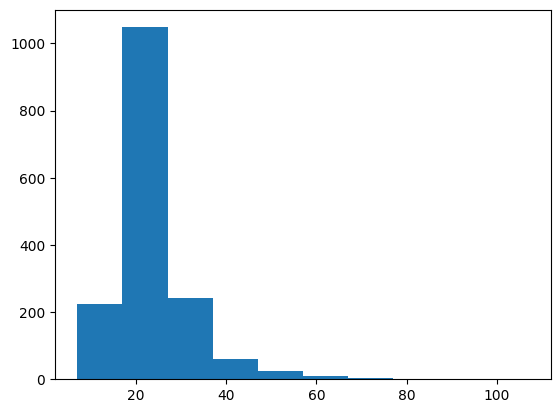

In [4]:
list_of_transcription_lengths = []

for sample in atco_asr_data['train']:
    text = sample['text']
    tokenized_text = tokenizer(text).input_ids
    list_of_transcription_lengths.append(len(tokenized_text))
    # break

plt.hist(list_of_transcription_lengths)
plt.show()

In [5]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["text"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [6]:
dataset = whisper_training_dataset(dataset=atco_asr_data['train'], max_len=60)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [7]:
def evaluation(model):

    atco_asr_data = load_dataset('parquet',data_files="validation-00000-of-00002-7a5ea3756991bf72.parquet")

    model.eval()

    predictions=[]
    references=[]

    for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
        audio=sample['audio']['array']
        sample_rate=sample['audio']['sampling_rate']
        text=sample['text']

        audio = down_sample_audio(audio, sample_rate) # downsample the audio to 16000Hz for WHISPER

        input_features = feature_extractor(
        raw_speech=audio,
        sampling_rate=16000,
        return_tensors='pt',
        padding=True).input_features

        # Generate predictions with no gradient computation
        with torch.no_grad():
            op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

        # Decode predictions
        text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

        # Append batch predictions and references to the respective lists
        predictions.extend(text_preds)
        references.extend([text])

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER



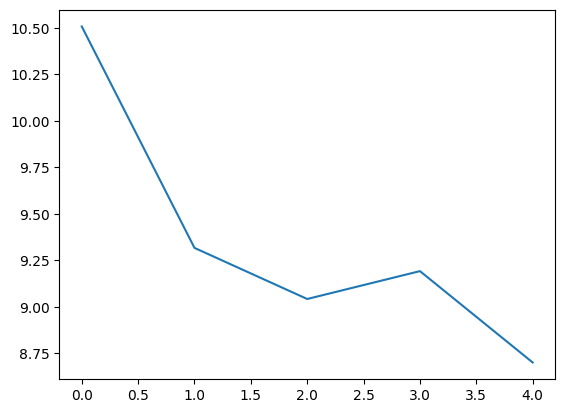

100%|██████████| 5/5 [40:13<00:00, 482.75s/it]


In [8]:
from IPython.display import clear_output

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)

max_epochs=5


running_wer=[]



for epoch in tqdm(range(max_epochs)):

    for batch in train_dataloader:

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

   
        
  
    running_wer.append(evaluation(model))
    plt.plot(running_wer)
    clear_output(wait=True)
    plt.xlabel('epochs')
    plt.ylabel('wer (%)')
    plt.show()
    


In [11]:
# torch.save(model.state_dict(), 'finetuned_atco.pth')# saving the model
model.load_state_dict(torch.load('finetuned_atco.pth', weights_only=True))# loading the model
model.eval()
model.to('cuda')

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [13]:
model.eval()
atco_asr_data = load_dataset('parquet',data_files="validation-00000-of-00002-7a5ea3756991bf72.parquet")

for idx in range(5):

    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    input_feature = feature_extractor(raw_speech=audio_original,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : Eurowings Seven Alfa Bravo turn right heading two one zero cleared ILS approach runway two four report established heading(-ding)  two one zero cleared for the ILS two four report established Eurowings Seven Alpha Bravo  
pred : Eurotrans Seven Alpha Bravo turn right heading two one zero cleared ILS approach runway two four report established same  two one zero cleared for the ILS two four report established Eurotrans Seven Alpha Bravo 

 
-------1------
true : Skytravel Two Eight Two Seven and there is closed echo airspace below flight level one hundred so  if you wish to avoid class echo airspace next descend in two zero miles  
pred : Skydrull Two Eight Two Seven and there is cross echo airspace below flight level one hundred so if you wish to avoid cross echo airspace next descend in two zero miles 

 
-------2------
true : Oscar Kilo Papa Romeo Mike turn right heading zero six zero zero six zero right turn Oscar Papa Romeo Mike  
pred : Oscar Kilo Papa Romeo 